<!-- 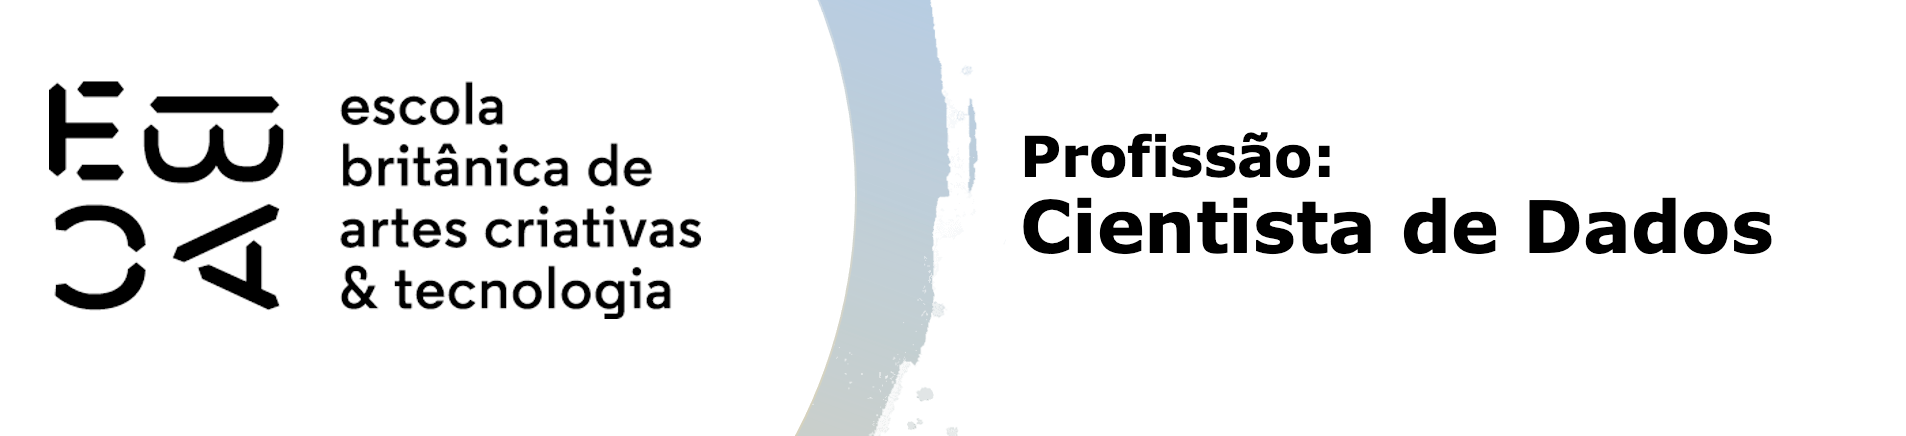 -->

[![ebac_logo-data_science.png](https://raw.githubusercontent.com/diegobezzi/DataScience_Estudos/main/ebac-course-utils/media/logo/ebac_logo-data_science.png)](https://github.com//diegobezzi/DataScience_Estudos)
<!-- <img src="https://raw.githubusercontent.com/diegobezzi/DataScience_Estudos/main/ebac-course-utils/media/logo/ebac_logo-data_science.png" alt="ebac_logo-data_science"> -->

---

<!-- # **Profissão: Cientista de Dados** -->
### **Módulo 38** | Projeto Final 

**Aluno:** [Diego Perez Bezzi Vilas Boas](https://www.linkedin.com/in/diegobezzi/)<br>
**Data:** 05 de Novembro de 2024.

---

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Identificar os três últimos meses de data_ref
ultimos_meses = df['data_ref'].sort_values().unique()[-3:]

# Separar os dados em treino e validação OOT
df_treino = df[~df['data_ref'].isin(ultimos_meses)].copy()
df_oot = df[df['data_ref'].isin(ultimos_meses)].copy()

# Remover as colunas data_ref e index
df_treino = df_treino.drop(columns=['data_ref', 'index'])
df_oot = df_oot.drop(columns=['data_ref', 'index'])

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Número total de linhas
total_linhas = df.shape[0]

# Número de linhas por mês em data_ref
linhas_por_mes = df['data_ref'].value_counts().sort_index()

print(f"Número total de linhas: {total_linhas}")
print("Número de linhas por mês em data_ref:")
print(linhas_por_mes)

Número total de linhas: 750000
Número de linhas por mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [5]:
# Identificação das variáveis qualitativas e quantitativas
qualitativas = df.select_dtypes(include=['object', 'category']).columns
quantitativas = df.select_dtypes(include=['number']).columns

# Descritiva para variáveis qualitativas
print("Descritiva das variáveis qualitativas:")
for col in qualitativas:
    print(f"\n{col}:")
    print(df[col].value_counts())

# Descritiva para variáveis quantitativas
print("\nDescritiva das variáveis quantitativas:")
df[quantitativas].describe().T

Descritiva das variáveis qualitativas:

sexo:
sexo
F    504580
M    245420
Name: count, dtype: int64

posse_de_veiculo:
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

posse_de_imovel:
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

tipo_renda:
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

educacao:
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: count, dtype: int64

estado_civil:
estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: count, dtype: int64

tipo_residencia:
tipo_residencia
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290
Name: count, dtype: i

,count,mean,std,min,25%,50%,75%,max
index,750000.0,8319.272793,4809.281774,0.000000,4147.000000,8324.000000,12487.000000,1.664900e+04
qtd_filhos,750000.0,0.433251,0.739379,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,624043.0,7.748574,6.687455,0.117808,3.049315,6.046575,10.183562,4.290685e+01
qt_pessoas_residencia,750000.0,2.212241,0.903428,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


In [6]:
# Separando as variáveis qualitativas
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
                'educacao', 'estado_civil', 'tipo_residencia']

# Separando as variáveis quantitativas
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

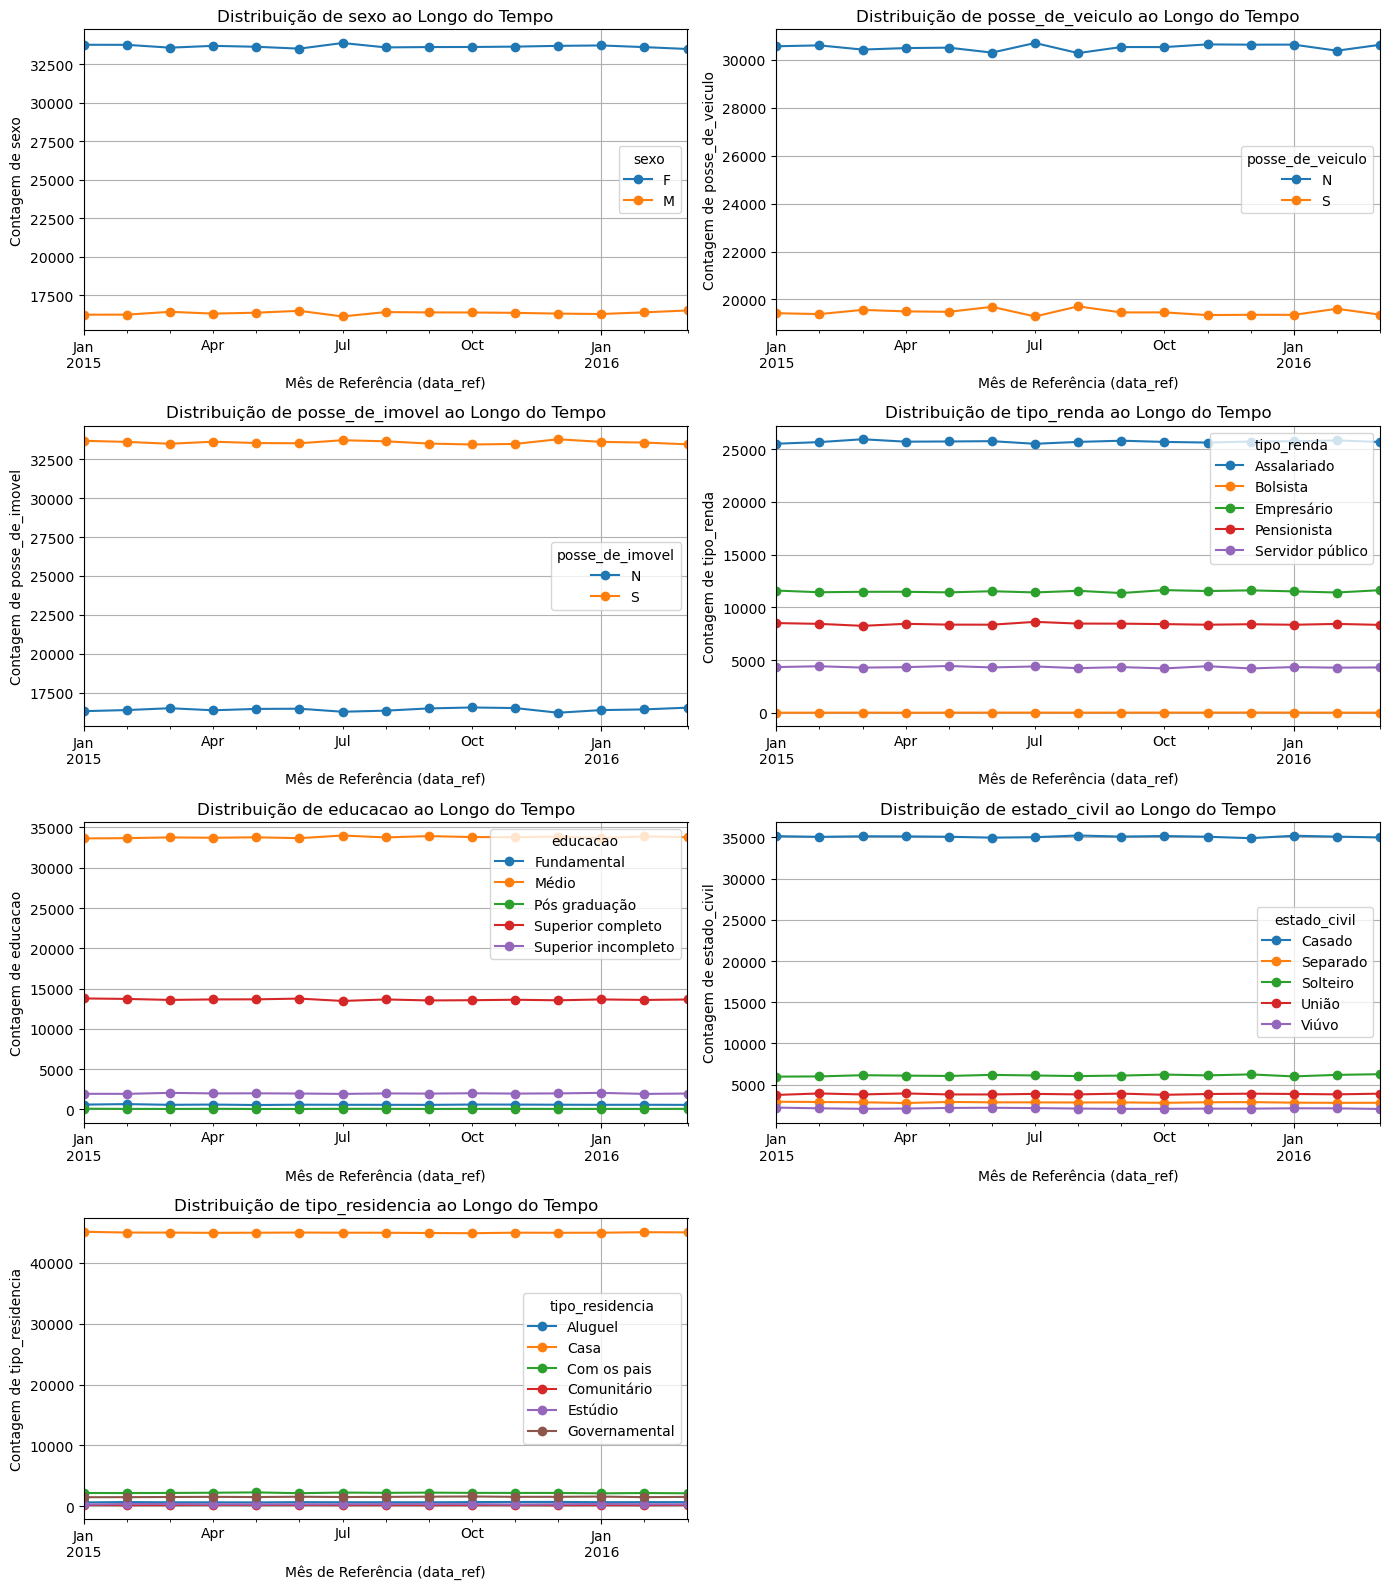

In [7]:
# Plotar a média de renda ao longo do tempo para cada variável qualitativa

# Configuração dos subplots: 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 16))  # 4 linhas para acomodar 7 gráficos, e 2 colunas

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativas):
    df.groupby(['data_ref', var]).size().unstack().plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Distribuição de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Contagem de {var}')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

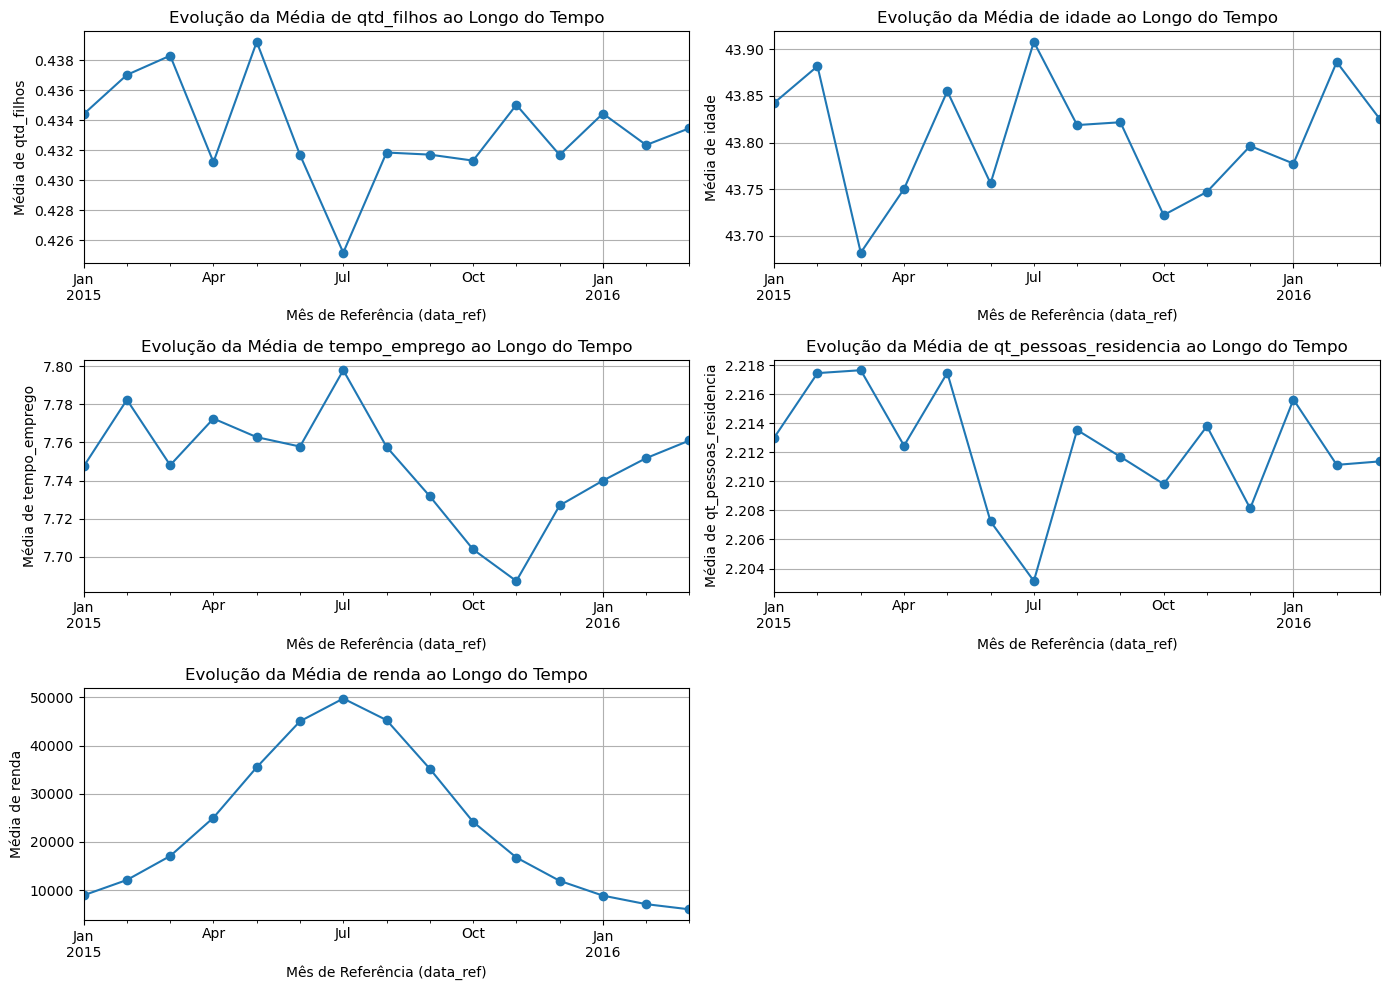

In [8]:
# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 4 gráficos, e 2 colunas

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativas):
    df.groupby('data_ref')[var].mean().plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Evolução da Média de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Média de {var}')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

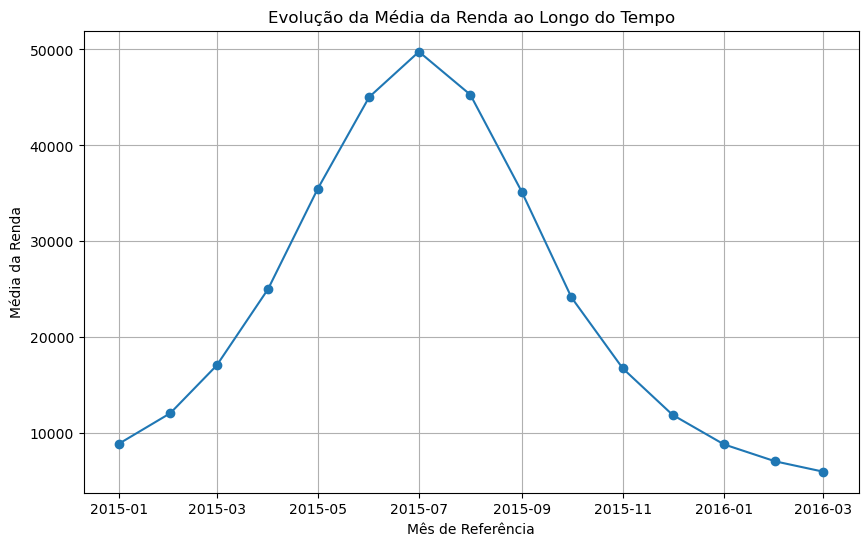

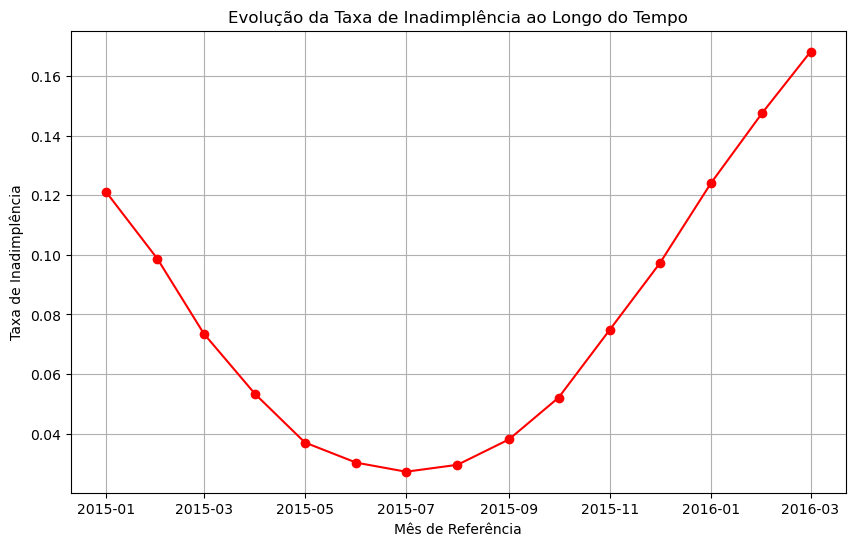

In [9]:
# Exemplo: Evolução da média da renda ao longo do tempo
renda_media_por_mes = df.groupby('data_ref')['renda'].mean()

plt.figure(figsize=(10, 6))
plt.plot(renda_media_por_mes.index, renda_media_por_mes.values, marker='o')
plt.title('Evolução da Média da Renda ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Média da Renda')
plt.grid(True)
plt.show()

# Exemplo: Evolução da taxa de inadimplência ao longo do tempo
# Assumindo que a variável de inadimplência seja binária (0 ou 1)
inadimplencia_por_mes = df.groupby('data_ref')['mau'].mean()

plt.figure(figsize=(10, 6))
plt.plot(inadimplencia_por_mes.index, inadimplencia_por_mes.values, marker='o', color='red')
plt.title('Evolução da Taxa de Inadimplência ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Taxa de Inadimplência')
plt.grid(True)
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

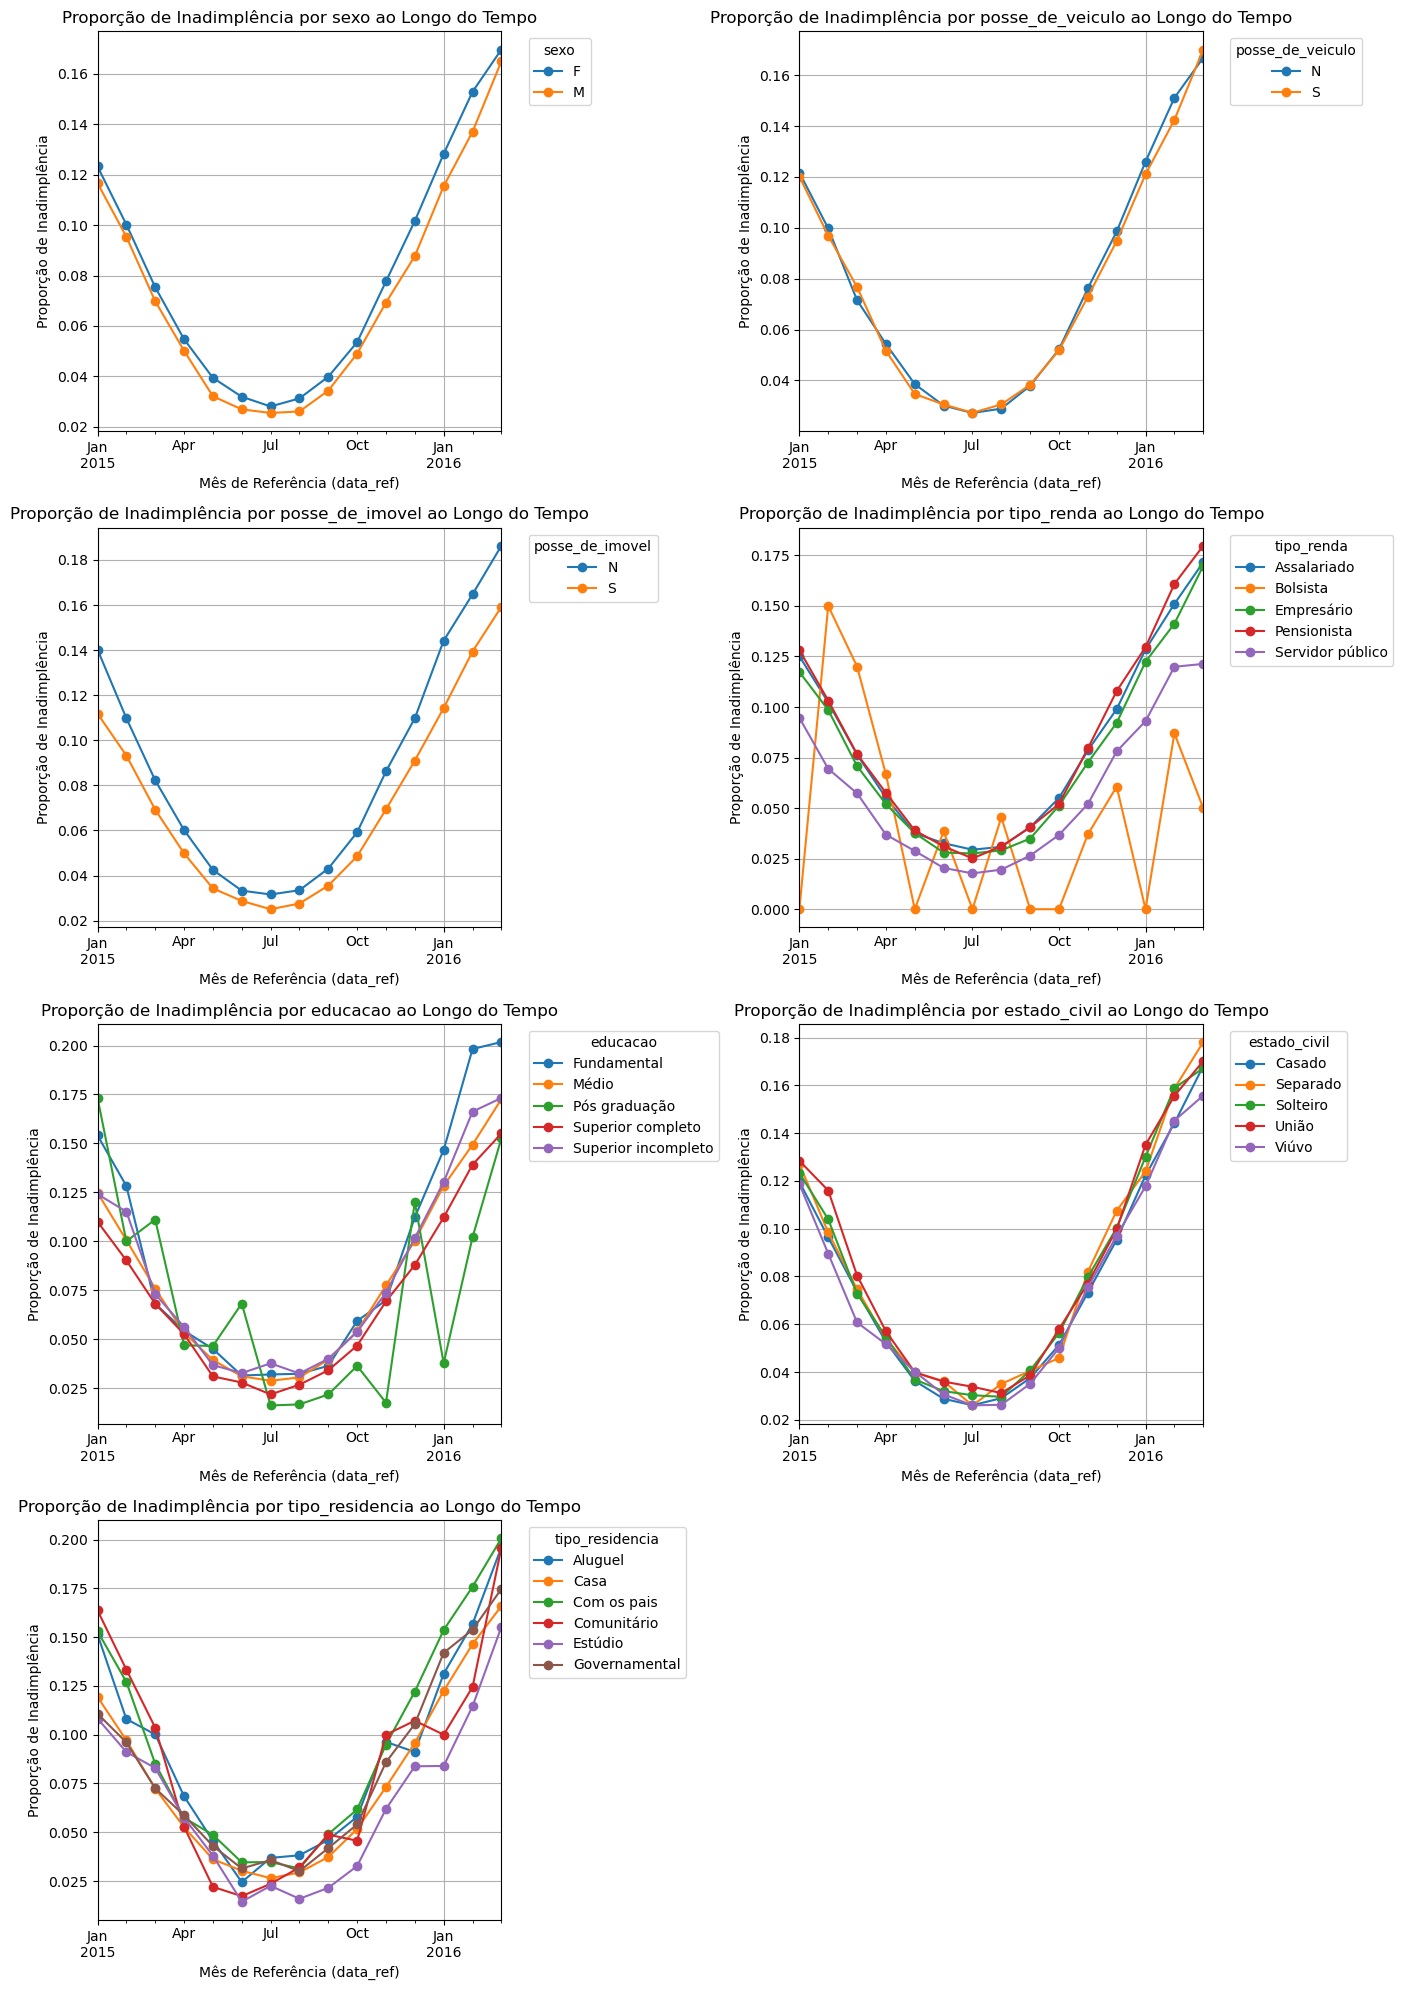

In [10]:
# Configuração dos subplots: 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # Tamanho ajustado para melhor visualização

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativas):
    # Calcular a proporção de inadimplência por data_ref e variável qualitativa
    data = df.groupby(['data_ref', var])['mau'].mean().unstack()
    
    # Plotar o gráfico
    data.plot(marker='o', linestyle='-', ax=axes[i])
    
    # Configurações do gráfico
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

# Remover o último subplot vazio se houver número ímpar de gráficos
if len(qualitativas) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


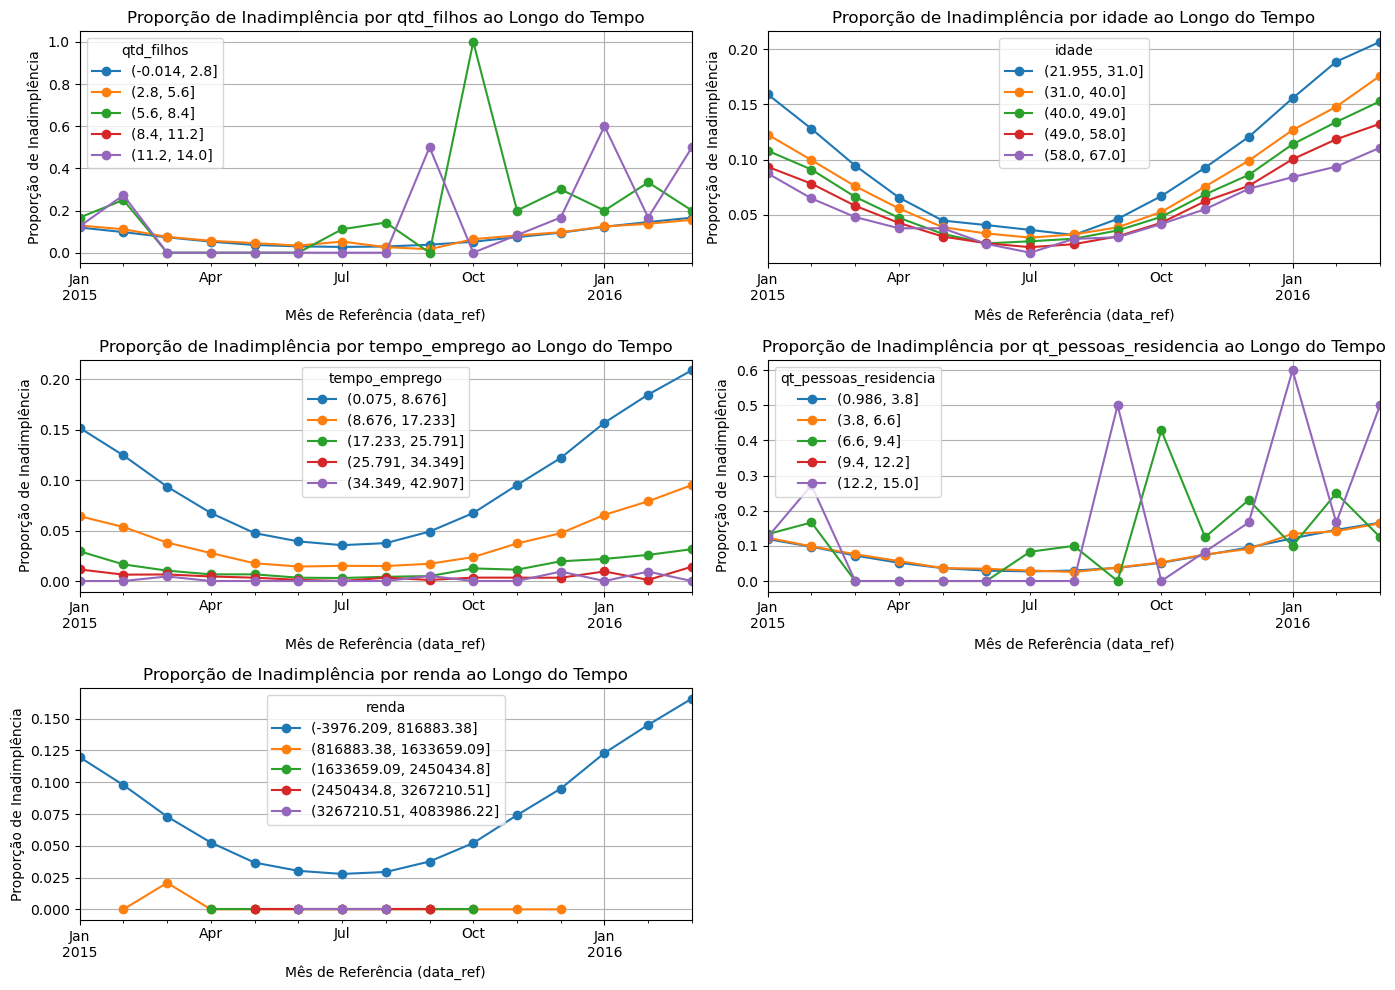

In [11]:
df = df.dropna(subset=quantitativas)

# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 5 gráficos, e 2 colunas

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativas):
    # Calcular a proporção de inadimplência por faixas da variável quantitativa ao longo do tempo
    data = df.groupby(['data_ref', pd.cut(df[var], bins=5)], observed=False)['mau'].mean().unstack()
    data.plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

>Obs: Fiz a remoção de N/A no gráfico anterior, pois devido à configuração de ambiente (diferente do módulo passado), o gráfico de **tempo_emprego** não estava sendo feito com esse código.

In [12]:
# Excluir a variável 'posse_de_veiculo' (não discrimina)
df = df.drop(columns=['posse_de_veiculo'])

# Agrupar quantidade de filhos acima de 5 em uma única categoria "5+"
df['qtd_filhos'] = df['qtd_filhos'].apply(lambda x: '<6' if x <= 5 else '6+')

# Remover categorias 'Pensionista' e 'Bolsista' da variável 'tipo_renda'
df = df[~df['tipo_renda'].isin(['Pensionista', 'Bolsista'])]

# Agrupar "Pós-graduação" em "Superior ou mais" na variável 'educacao'
df['educacao'] = df['educacao'].replace({'Pós-graduação': 'Superior ou mais'})

# Criar nova variável 'faixa_idade', categorizando como "<30" e "30+"
df['faixa_idade'] = df['idade'].apply(lambda x: '<30' if x < 30 else '30+')

# Agrupar tempo de emprego acima de 25 anos em "25+ anos"
df['tempo_emprego'] = df['tempo_emprego'].apply(lambda x: "<25" if x < 25 else '25+ anos')

# Agrupar quantidade de pessoas na residência acima de 6 em "6+"
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].apply(lambda x: '<7' if x <= 6 else '7+')

# Limitar a renda a valores de até 800.000 para tratar outliers
df = df[df['renda'] <= 800000]

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Ordenando os dados por data
df_sorted = df.sort_values(by='data_ref')

# Definindo o período de corte para os últimos 3 meses
cutoff_date = df_sorted['data_ref'].max() - pd.DateOffset(months=3)

# Dividindo os dados em treino e teste com base na data
train_df = df_sorted[df_sorted['data_ref'] <= cutoff_date]
test_df = df_sorted[df_sorted['data_ref'] > cutoff_date]

# Criando variáveis dummy para as variáveis categóricas
X_train = pd.get_dummies(train_df.drop(columns=['mau', 'data_ref', 'index']))
X_test = pd.get_dummies(test_df.drop(columns=['mau', 'data_ref', 'index']))

# Garantindo que X_test e X_train tenham as mesmas colunas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Definindo y para treino e teste
y_train = train_df['mau']
y_test = test_df['mau']

In [14]:
# Ajustando o modelo de Regressão Logística com class_weight='balanced'
model = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=66)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=66)

In [16]:
# Ajustando o limiar para a classificação
threshold = 0.69 # Valor ajustado

# Avaliação na base de treino
y_prob_train = model.predict_proba(X_train)[:, 1]  # Probabilidades para a classe positiva na base de treino
y_pred_train_adjusted = (y_prob_train > threshold).astype(int)  # Aplicando o limiar ajustado

# Avaliação na base de teste
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva na base de teste
y_pred_test_adjusted = (y_prob_test > threshold).astype(int)  # Aplicando o limiar ajustado

# Matriz de Confusão e Relatório de Classificação para a base de treino
conf_matrix_train = confusion_matrix(y_train, y_pred_train_adjusted)
class_report_train = classification_report(y_train, y_pred_train_adjusted)

# Matriz de Confusão e Relatório de Classificação para a base de teste
conf_matrix_test = confusion_matrix(y_test, y_pred_test_adjusted)
class_report_test = classification_report(y_test, y_pred_test_adjusted)

print("Avaliação na Base de Treino:")
print("Matriz de Confusão:")
print(conf_matrix_train)
print("\nRelatório de Classificação:")
print(class_report_train)

print("\nAvaliação na Base de Teste:")
print("Matriz de Confusão:")
print(conf_matrix_test)
print("\nRelatório de Classificação:")
print(class_report_test)


Avaliação na Base de Treino:
Matriz de Confusão:
[[458860   8311]
 [ 26997   3133]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96    467171
        True       0.27      0.10      0.15     30130

    accuracy                           0.93    497301
   macro avg       0.61      0.54      0.56    497301
weighted avg       0.90      0.93      0.91    497301


Avaliação na Base de Teste:
Matriz de Confusão:
[[98740  7995]
 [14053  4004]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.88      0.93      0.90    106735
        True       0.33      0.22      0.27     18057

    accuracy                           0.82    124792
   macro avg       0.60      0.57      0.58    124792
weighted avg       0.80      0.82      0.81    124792



## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [26]:
def ks_statistic(y_true, y_prob):
    """Calcula a estatística KS"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    return max(tpr - fpr)

def gini_coefficient(y_true, y_prob):
    """Calcula o coeficiente Gini"""
    return 2 * roc_auc_score(y_true, y_prob) - 1

# Métricas na base de treino
accuracy_train = accuracy_score(y_train, y_pred_train_adjusted)
ks_train = ks_statistic(y_train, y_prob_train)
gini_train = gini_coefficient(y_train, y_prob_train)

# Métricas na base de teste (OOT)
accuracy_test = accuracy_score(y_test, y_pred_test_adjusted)
ks_test = ks_statistic(y_test, y_prob_test)
gini_test = gini_coefficient(y_test, y_prob_test)

# Exibindo os resultados
print("Avaliação na Base de Treino:")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"KS: {ks_train:.4f}")
print(f"Gini: {gini_train:.4f}")

print("\nAvaliação na Base Out-of-Time (Teste):")
print(f"Acurácia: {accuracy_test:.4f}")
print(f"KS: {ks_test:.4f}")
print(f"Gini: {gini_test:.4f}")


Avaliação na Base de Treino:
Acurácia: 0.9290
KS: 0.4057
Gini: 0.5420

Avaliação na Base Out-of-Time (Teste):
Acurácia: 0.8233
KS: 0.3227
Gini: 0.4420


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

> Os dados nulos no **tempo_emprego** correspondem à categoria **pensionista**, não faz sentido substituí-los, vamos eliminar os dados.

In [35]:
# 1. Substituição de nulos
def substituir_nulos(df):
    df.dropna(inplace=True)
    return df

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

>Os *outliers* são os dados que estão fora do intervalo entre 1,5 vezes o IQR abaixo do primeiro quartil (Q1) e 1,5 vezes o IQR acima do terceiro quartil (Q3).

In [36]:
# 2. Remoção de outliers
def remover_outliers(df):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [37]:
# 3. Criação de dummies
def criar_dummies(df):
    return pd.get_dummies(df, drop_first=True)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [38]:
# 4. Seleção de variáveis usando feature importance
def selecionar_variaveis(X, y, n_features=8):
    model = RandomForestClassifier()
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n_features:]  # Seleciona os índices das n_features mais importantes
    selected_columns = X.columns[indices] # Nomes das variáveis selecionadas
    print("Variáveis selecionadas:", selected_columns)
    return X[selected_columns]

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [39]:
# 5. Aplicação de PCA
def aplicar_pca(X, n_components=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [40]:
# Função para criar o pipeline
def preprocessamento(df):
    y = df['mau']
    X = df.drop(columns=['mau'])
    
    # Aplicar as funções de pré-processamento
    df = substituir_nulos(df)
    df = remover_outliers(df)
    X = criar_dummies(X)    
     
    # Seleção de variáveis
    X_selecionado = selecionar_variaveis(X, y, n_features=8)    
      
    # Aplicação de PCA
    X_pca = aplicar_pca(X_selecionado, n_components=5)
    
    # Adicionar a variável alvo de volta
    X_pca['mau'] = y.reset_index(drop=True)
    
    return X_pca

In [41]:
# Função de transformação que usa a função de pré-processamento
def preprocessamento_transformer(df):
    return preprocessamento(df)

# Criação da pipeline
preprocessamento_pipeline = Pipeline([
    ('preprocessamento', FunctionTransformer(preprocessamento_transformer, validate=False)),
])

In [42]:
df_processado = preprocessamento_pipeline.transform(df_treino)
print(df_processado.head())

Variáveis selecionadas: Index(['sexo_M', 'qtd_filhos', 'tipo_renda_Empresário', 'posse_de_veiculo_S',
       'qt_pessoas_residencia', 'idade', 'tempo_emprego', 'renda'],
      dtype='object')
        PC1       PC2       PC3       PC4       PC5    mau
0 -1.406512 -1.126643 -1.133713  1.272389 -0.059558  False
1  0.020947 -0.786442  0.271998 -0.527138  0.339180  False
2  2.456414  0.965567 -1.788327 -0.662595  0.207745  False
3 -1.644986  0.476788 -0.579556 -0.760518 -0.915149  False
4 -0.560758 -0.989393  0.435520 -0.503728  0.947348  False


### Treinar um modelo de regressão logistica com o resultado

In [43]:
def ajustar_regressao_logistica(X_train, y_train):
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    return model

In [44]:
X_train = df_processado.drop(columns=['mau'])
y_train = df_processado['mau']

In [45]:
model = ajustar_regressao_logistica(X_train, y_train)

### Salvar o pickle file do modelo treinado

In [46]:
nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

### Uma rápida análise na base OOT

In [47]:
df_oot_processado = preprocessamento(df_oot)
X_oot = df_oot_processado.drop(columns='mau')
y_oot = df_oot['mau']

y_probs = model.predict_proba(X_oot)[:, 1]
threshold = 0.67
y_pred_threshold = (y_probs >= threshold).astype(int)

cm = confusion_matrix(y_oot, y_pred_threshold)
print(cm)

Variáveis selecionadas: Index(['sexo_M', 'tipo_renda_Empresário', 'qtd_filhos', 'posse_de_veiculo_S',
       'qt_pessoas_residencia', 'idade', 'tempo_emprego', 'renda'],
      dtype='object')


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
resultados_preditos = df_oot.copy()
resultados_preditos['Previsoes'] = y_pred_threshold
resultados_preditos.head()

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [48]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [49]:
dataset = df.sample(50000)

In [50]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [51]:
data = dataset.sample(frac=0.95, random_state=222)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [52]:
data.qtd_filhos = data.qtd_filhos.astype(float) #forçando a variável qnt de filhos como numérica

In [53]:
from pycaret.classification import *


In [54]:
clf = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.9%


In [55]:
lightgbm = create_model('lightgbm', class_weight='balanced')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7152,0.7746,0.6691,0.1734,0.2754,0.1686,0.2286
1,0.7053,0.7398,0.6097,0.1578,0.2508,0.1403,0.1902
2,0.7284,0.7580,0.6691,0.1811,0.2850,0.1807,0.2399
3,0.7131,0.7589,0.6617,0.1710,0.2718,0.1643,0.2230
4,0.7236,0.7709,0.6617,0.1769,0.2792,0.1737,0.2320
5,0.7110,0.7757,0.6803,0.1730,0.2758,0.1685,0.2306
6,0.7209,0.7874,0.6617,0.1754,0.2773,0.1713,0.2296
7,0.7173,0.7697,0.6729,0.1752,0.2780,0.1717,0.2322
8,0.7239,0.7555,0.6296,0.1721,0.2703,0.1636,0.2163


In [56]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7558,0.7376,0.5428,0.1749,0.2645,0.1619,0.1995
1,0.7438,0.7006,0.4833,0.1542,0.2338,0.1267,0.1567
2,0.7663,0.7199,0.5539,0.1849,0.2772,0.1774,0.2157
3,0.7576,0.7095,0.5130,0.1697,0.2551,0.1520,0.1853
4,0.7663,0.7456,0.5725,0.1887,0.2839,0.1847,0.2255
5,0.7558,0.7443,0.5613,0.1787,0.2711,0.1691,0.2093
6,0.7444,0.7486,0.5762,0.1740,0.2672,0.1632,0.2065
7,0.7699,0.7166,0.4907,0.1737,0.2566,0.1557,0.1852
8,0.7510,0.7328,0.5333,0.1702,0.2581,0.1539,0.1904


Fitting 10 folds for each of 10 candidates, totalling 100 fits


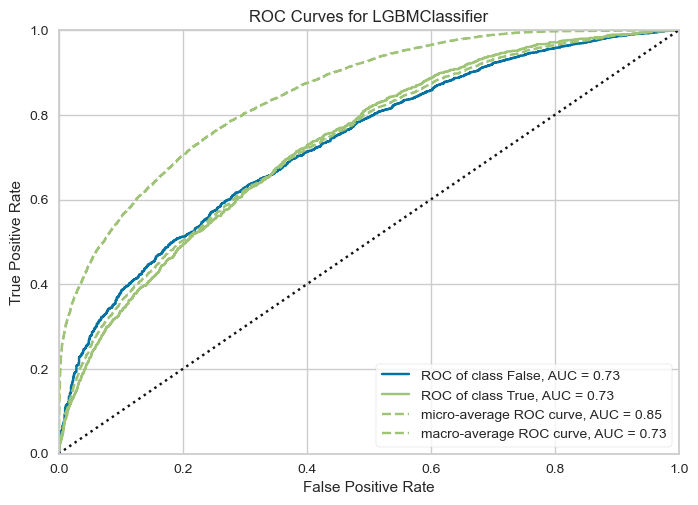

In [57]:
plot_model(tuned_lightgbm, plot='auc')

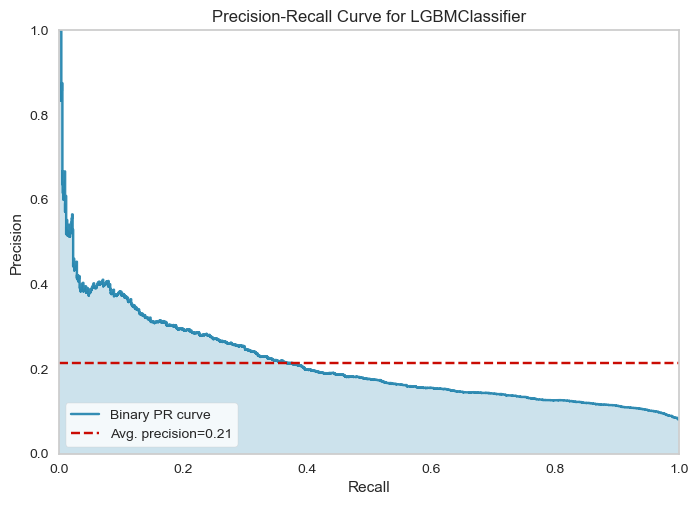

In [58]:
plot_model(tuned_lightgbm, plot = 'pr')

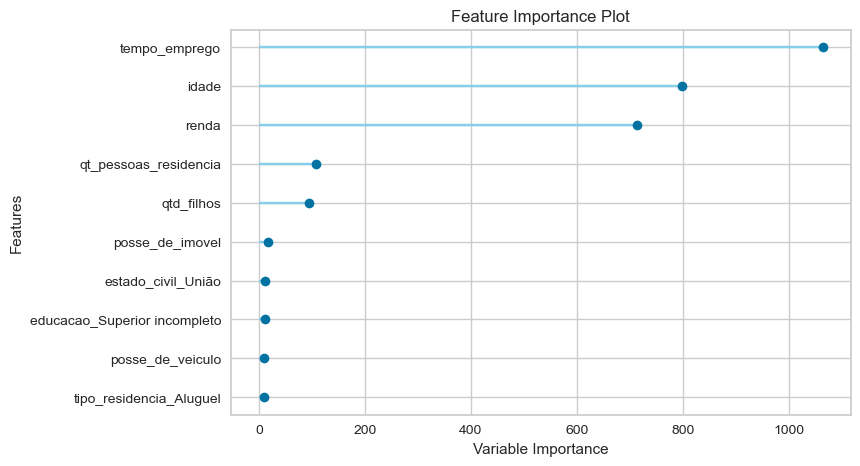

In [59]:
plot_model(tuned_lightgbm, plot='feature')

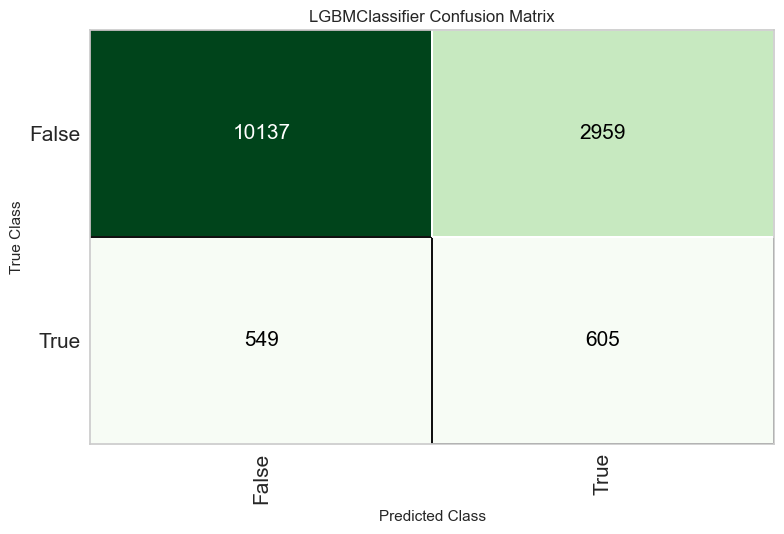

In [60]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [61]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [62]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7538,0.7315,0.5243,0.1698,0.2565,0.1528,0.1879


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
16187,M,N,N,0.0,Assalariado,Superior incompleto,Casado,Casa,27,0.756164,2.0,20672.650391,False,0,0.9897
27536,F,N,S,0.0,Pensionista,Médio,Separado,Casa,64,NaN,1.0,4844.770020,False,1,0.6742
3795,F,S,N,2.0,Servidor público,Superior completo,Casado,Casa,43,20.189041,4.0,105608.757812,False,0,0.9795
46433,M,S,S,0.0,Pensionista,Médio,União,Casa,67,NaN,2.0,13520.320312,False,0,0.9300
6552,M,S,S,0.0,Assalariado,Médio,Casado,Casa,45,2.876712,2.0,2188.929932,False,1,0.8299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,F,N,N,0.0,Assalariado,Superior completo,Casado,Casa,38,20.273973,2.0,111474.429688,False,0,0.9967
24733,F,N,N,0.0,Empresário,Superior completo,Casado,Casa,31,10.304110,2.0,10905.219727,False,0,0.7253
45632,F,N,N,0.0,Servidor público,Superior completo,União,Casa,60,14.287671,2.0,17756.369141,False,0,0.8413
28670,F,S,S,2.0,Servidor público,Médio,União,Casa,36,15.936986,4.0,22503.509766,False,0,0.9317


In [63]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [64]:
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight='balanced',
                     

In [65]:
predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7581,0.8871,0.8960,0.2371,0.3750,0.2832,0.3800


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [66]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7340,0.7569,0.6146,0.1664,0.2619,0.1605,0.2118


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,N,1,Empresário,Superior completo,Solteiro,Casa,27,4.523288,2.0,12200.730469,False,0,0.6602
1,F,S,N,1,Assalariado,Médio,Casado,Casa,39,8.789042,3.0,19378.619141,False,0,0.8595
2,F,N,N,0,Assalariado,Médio,Casado,Governamental,45,27.364384,2.0,57926.660156,False,0,0.9881
3,M,S,S,0,Assalariado,Médio,Casado,Casa,49,0.547945,2.0,2221.449951,True,1,0.7684
4,M,S,S,2,Assalariado,Médio,Casado,Casa,26,6.257534,4.0,14813.339844,False,0,0.9602


### Salvar o arquivo do modelo treinado

In [68]:
save_model(final_lightgbm,'Final LightGBM Model 05Nov2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight='balanced',
      

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.